In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation

In [2]:
sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest"), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

In [13]:
b = bagreader('/home/msccomputer/Desktop/2022-10-25-13-25-43.bag')

b.topic_table

[INFO]  Data folder /home/msccomputer/Desktop/2022-10-25-13-25-43 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,373,31.670661
1,/anafi/battery,std_msgs/UInt8,371,32.150731
2,/anafi/gnss_location,sensor_msgs/NavSatFix,373,31.474119
3,/anafi/height,olympe_bridge/Float32Stamped,373,31.910893
4,/anafi/image,sensor_msgs/Image,374,31.746170
5,/anafi/link_goodput,std_msgs/UInt16,372,31.689565
6,/anafi/link_quality,std_msgs/UInt8,372,32.359961
7,/anafi/odometry,nav_msgs/Odometry,340,22.809634
8,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,372,31.533038
9,/anafi/polled_body_velocities,geometry_msgs/TwistStamped,57,5.021777


In [14]:
gt_anafi_pose = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pose = pd.read_csv(gt_anafi_pose)

df_gt_anafi_pose = drop_columns_in_df(df_gt_anafi_pose)
df_gt_anafi_pose.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_anafi_pose = rename_columns(df_gt_anafi_pose, ["anafi_x", "anafi_y", "anafi_z"])

df_gt_anafi_pose

,Time,anafi_x,anafi_y,anafi_z
0,1.666697e+09,0.000628,-0.381263,-0.142540
1,1.666697e+09,0.000653,-0.381278,-0.142496
2,1.666697e+09,0.000644,-0.381243,-0.142502
3,1.666697e+09,0.000597,-0.381284,-0.142535
4,1.666697e+09,0.000685,-0.381236,-0.142555
...,...,...,...,...
1245,1.666697e+09,0.000671,-0.381258,-0.142531
1246,1.666697e+09,0.000643,-0.381273,-0.142518
1247,1.666697e+09,0.000644,-0.381239,-0.142494
1248,1.666697e+09,0.000692,-0.381244,-0.142567


In [15]:
gt_platform_pose = b.message_by_topic('/qualisys/Platform/pose')
df_gt_platform_pose = pd.read_csv(gt_platform_pose)

df_gt_platform_pose = drop_columns_in_df(df_gt_platform_pose)
df_gt_platform_pose.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_platform_pose = rename_columns(df_gt_platform_pose, ["platform_x", "platform_y", "platform_z"])

df_gt_platform_pose

,Time,platform_x,platform_y,platform_z
0,1.666697e+09,0.003753,-0.378844,-0.108346
1,1.666697e+09,0.003755,-0.378846,-0.108329
2,1.666697e+09,0.003748,-0.378857,-0.108345
3,1.666697e+09,0.003750,-0.378854,-0.108347
4,1.666697e+09,0.003756,-0.378840,-0.108325
...,...,...,...,...
1246,1.666697e+09,0.003767,-0.378848,-0.108345
1247,1.666697e+09,0.003764,-0.378826,-0.108342
1248,1.666697e+09,0.003768,-0.378848,-0.108376
1249,1.666697e+09,0.003762,-0.378846,-0.108379


In [16]:
# Load the drone orientation from the anafi
from math import degrees


gt_anafi_pose_NED = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pose_NED = pd.read_csv(gt_anafi_pose)

# Load the position of the platform
gt_platform_pose_NED = b.message_by_topic('/qualisys/Platform/pose')
df_gt_platform_pose_NED = pd.read_csv(gt_platform_pose)
df_gt_platform_pose_NED = drop_columns_in_df(df_gt_platform_pose_NED)
df_gt_platform_pose_NED.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_platform_pose_NED = rename_columns(df_gt_platform_pose_NED, ["platform_x", "platform_y", "platform_z"])

# Sync the two dataframes based on timestamps
df_gt_NED = sync_dfs_based_on_time([df_gt_anafi_pose_NED, df_gt_platform_pose_NED])

# Create the rotation objects and apply the rotations to the pose of the platform
df_rotation_NED_to_body = df_gt_NED[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
# rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body)

rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body).as_euler("xyz", degrees=True)
rotation_NED_to_body[2,:] += 0
# np.array([np.array(rotation_NED_to_body[0,:]).T, np.array(rotation_NED_to_body[1,:]).T, np.array(rotation_NED_to_body[2,:]).T]).T
rotation_NED_to_body= Rotation.from_euler('xyz', rotation_NED_to_body, degrees=True).inv()


platform_pos_body = rotation_NED_to_body.apply(df_gt_NED[["platform_x", "platform_y", "platform_z"]])
df_platform_pos_body = pd.DataFrame(platform_pos_body)
df_platform_pos_body.columns = ["platform_x_body", "platform_y_body", "platform_z_body"]

# Get the anafi position in the body frame
anafi_pos_body = rotation_NED_to_body.apply(df_gt_NED[["pose.position.x", "pose.position.y", "pose.position.z"]])
df_anafi_pos_body = pd.DataFrame(anafi_pos_body)
df_anafi_pos_body.columns = ["anafi_x_body", "anafi_y_body", "anafi_z_body"]

conc = [df_gt_NED, df_platform_pos_body, df_anafi_pos_body]

df_positions_body = pd.concat(
    conc,
    axis=1,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

df_positions_body = df_positions_body[["Time", "platform_x_body", "platform_y_body", "platform_z_body", "anafi_x_body", "anafi_y_body", "anafi_z_body"]]

df_positions_body['drone_to_platform_body_x'] = df_positions_body["platform_x_body"] - df_positions_body["anafi_x_body"]
df_positions_body['drone_to_platform_body_y'] = df_positions_body["platform_y_body"] - df_positions_body["anafi_y_body"]
df_positions_body['drone_to_platform_body_z'] = df_positions_body["platform_z_body"] - df_positions_body["anafi_z_body"]

df_positions_body


,Time,platform_x_body,platform_y_body,platform_z_body,anafi_x_body,anafi_y_body,anafi_z_body,drone_to_platform_body_x,drone_to_platform_body_y,drone_to_platform_body_z
0,1.666697e+09,0.383096,0.063728,-0.066704,0.389700,0.061101,-0.100400,-0.006604,0.002627,0.033697
1,1.666697e+09,0.383093,0.063737,-0.066808,0.389679,0.061143,-0.100448,-0.006587,0.002593,0.033640
2,1.666697e+09,0.383117,0.063751,-0.066636,0.389689,0.061153,-0.100281,-0.006572,0.002598,0.033645
3,1.666697e+09,0.383165,0.063644,-0.066352,0.389830,0.060980,-0.100039,-0.006665,0.002663,0.033686
4,1.666697e+09,0.383130,0.063776,-0.066566,0.389693,0.061215,-0.100274,-0.006563,0.002560,0.033708
...,...,...,...,...,...,...,...,...,...,...
1245,1.666697e+09,0.383151,0.063632,-0.066520,0.389755,0.061042,-0.100191,-0.006604,0.002591,0.033671
1246,1.666697e+09,0.383111,0.063568,-0.066682,0.389742,0.060942,-0.100339,-0.006631,0.002626,0.033657
1247,1.666697e+09,0.383121,0.063740,-0.066644,0.389695,0.061119,-0.100251,-0.006574,0.002620,0.033607
1248,1.666697e+09,0.383094,0.063746,-0.066780,0.389663,0.061184,-0.100458,-0.006569,0.002563,0.033679


In [17]:
df_merged_position = sync_dfs_based_on_time([df_positions_body])

df_merged_position.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 0 to 1249
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Time                      1250 non-null   float64
 1   platform_x_body           1250 non-null   float64
 2   platform_y_body           1250 non-null   float64
 3   platform_z_body           1250 non-null   float64
 4   anafi_x_body              1250 non-null   float64
 5   anafi_y_body              1250 non-null   float64
 6   anafi_z_body              1250 non-null   float64
 7   drone_to_platform_body_x  1250 non-null   float64
 8   drone_to_platform_body_y  1250 non-null   float64
 9   drone_to_platform_body_z  1250 non-null   float64
dtypes: float64(10)
memory usage: 107.4 KB


In [18]:
df_merged_position = normalize_df_time(df_merged_position)

column_names = df_merged_position.columns

array_df_merged_position = df_merged_position.to_numpy()

df_merged_position

,Time,platform_x_body,platform_y_body,platform_z_body,anafi_x_body,anafi_y_body,anafi_z_body,drone_to_platform_body_x,drone_to_platform_body_y,drone_to_platform_body_z
0,0.000000,0.383096,0.063728,-0.066704,0.389700,0.061101,-0.100400,-0.006604,0.002627,0.033697
1,0.009480,0.383093,0.063737,-0.066808,0.389679,0.061143,-0.100448,-0.006587,0.002593,0.033640
2,0.018981,0.383117,0.063751,-0.066636,0.389689,0.061153,-0.100281,-0.006572,0.002598,0.033645
3,0.029193,0.383165,0.063644,-0.066352,0.389830,0.060980,-0.100039,-0.006665,0.002663,0.033686
4,0.038763,0.383130,0.063776,-0.066566,0.389693,0.061215,-0.100274,-0.006563,0.002560,0.033708
...,...,...,...,...,...,...,...,...,...,...
1245,12.449000,0.383151,0.063632,-0.066520,0.389755,0.061042,-0.100191,-0.006604,0.002591,0.033671
1246,12.458217,0.383111,0.063568,-0.066682,0.389742,0.060942,-0.100339,-0.006631,0.002626,0.033657
1247,12.468743,0.383121,0.063740,-0.066644,0.389695,0.061119,-0.100251,-0.006574,0.002620,0.033607
1248,12.478606,0.383094,0.063746,-0.066780,0.389663,0.061184,-0.100458,-0.006569,0.002563,0.033679


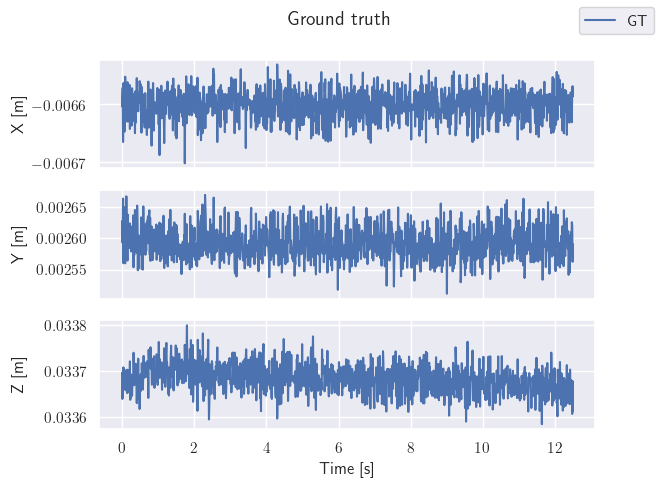

In [20]:
fig, axs = plt.subplots(3, 1)


axs[0].plot(array_df_merged_position[:,0], array_df_merged_position[:,7])
axs[0].set_xticklabels([])
axs[0].set_ylabel('X [m]')
axs[0].grid(True)

axs[1].plot(array_df_merged_position[:,0], array_df_merged_position[:,8])
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

axs[2].plot(array_df_merged_position[:,0], array_df_merged_position[:,9])
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[0].get_legend_handles_labels()
labels = ["GT"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Ground truth', fontsize=14)
fig.align_ylabels(axs)

plt.show()